## Usecase: Predicting Fraud in Financial Payment Services

### Problem Statement: 

- To solve below issues by a detailed data exploration and cleaning followed by choosing a suitable machine-learning algorithm to deal with the skew with a optimal solution based on feature engineering and extreme gradient-boosted decision trees.

#### Issues: 
1. To predicting fraud is the highly imbalanced distribution between positive and negative classes in 6 million rows of data without artificial balancing of the data.
2. Block to the utility of this data stems from the possible discrepancies in its description.

##### Columns Descriptions:

step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount -
amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
df=pd.read_csv("C:/Users/subha/Upgrad/BFSI/Predicting Fraud in Financial Payment Services/dataset/finance_data.csv")
df.head()

step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0

## EDA

In [3]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [4]:
""" Target variable is highly imbalanced."""
df['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [5]:
'''Ratio of fraud and non-fraud data.'''
(df['isFraud'].value_counts()[0]/len(df.index))*100, (df['isFraud'].value_counts()[1]/len(df.index))*100

(99.87091795518198, 0.12908204481801522)

In [6]:
'''Checking of duplicate records'''
print('The number of duplicate records: ', len(df[df.duplicated()]))

The number of duplicate records:  0


### Analysing the types of fraud

#### Let's find the types of transaction

In [7]:
''' All types of types of transactions.'''
df['type'].value_counts()

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

In [8]:
'''The type of fradulent transactions'''
df[df['isFraud']==1]['type'].value_counts()

CASH_OUT    4116
TRANSFER    4097
Name: type, dtype: int64

### 2.1. Which types of transactions are fraudulent?

In [9]:
print('\n The types of fraudulent transactions are {}'.format(\
list(df.loc[df.isFraud == 1].type.drop_duplicates().values))) # only 'CASH_OUT' 
                                                             # & 'TRANSFER'

dfFraudTransfer = df.loc[(df.isFraud == 1) & (df.type == 'TRANSFER')]
dfFraudCashout = df.loc[(df.isFraud == 1) & (df.type == 'CASH_OUT')]

print ('\n The number of fraudulent TRANSFERs = {}'.\
       format(len(dfFraudTransfer))) # 4097

print ('\n The number of fraudulent CASH_OUTs = {}'.\
       format(len(dfFraudCashout))) # 4116


 The types of fraudulent transactions are ['TRANSFER', 'CASH_OUT']

 The number of fraudulent TRANSFERs = 4097

 The number of fraudulent CASH_OUTs = 4116


Output: The number of fradulent transfer and cashout transaction are same.

<AxesSubplot:xlabel='type', ylabel='count'>

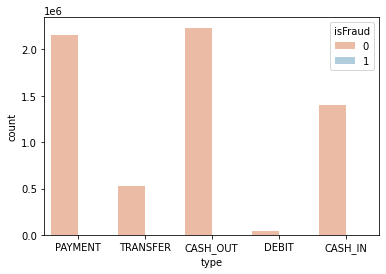

In [10]:
'''Checking the value distribution of the type of transaction'''
sns.countplot( x = 'type',data=df, hue='isFraud', palette="RdBu")

### 2.2. What determines whether the feature isFlaggedFraud gets set or not?

In [11]:
df['isFlaggedFraud'].value_counts()

0    6362604
1         16
Name: isFlaggedFraud, dtype: int64

In [12]:
df[df['isFlaggedFraud']==1]['type'].drop_duplicates().value_counts()

TRANSFER    1
Name: type, dtype: int64

### Relationship between type, amount, isFlaggedFraud
The 16 entries (out of 6 million) where the isFlaggedFraud feature is set do not seem to correlate with any explanatory variable. The data is described as isFlaggedFraud being set when an attempt is made to 'TRANSFER' an 'amount' greater than 200,000.

In [13]:
print('\nThe type of transactions in which isFlaggedFraud is set: \
{}'.format(list(df.loc[df.isFlaggedFraud == 1].type.drop_duplicates()))) 

dfTransfer = df.loc[df.type == 'TRANSFER']
dfFlagged = df.loc[df.isFlaggedFraud == 1]
dfNotFlagged = df.loc[df.isFlaggedFraud == 0]

df[(df['isFlaggedFraud']==1) & (df['type']=='TRANSFER')]['amount']

print('\nMin amount transacted when isFlaggedFraud is set= {}'\
                                  .format(dfFlagged.amount.min())) # 353874.22

print('\nMax amount transacted in a TRANSFER where isFlaggedFraud is not set=\
 {}'.format(dfTransfer.loc[dfTransfer.isFlaggedFraud == 0].amount.max())) # 92445516.64


The type of transactions in which isFlaggedFraud is set: ['TRANSFER']

Min amount transacted when isFlaggedFraud is set= 353874.22

Max amount transacted in a TRANSFER where isFlaggedFraud is not set= 92445516.64


In [14]:
'''Let check the statistical analysis of the amount'''
df.describe()

step        amount  oldbalanceOrg  newbalanceOrig  \
count  6.362620e+06  6.362620e+06   6.362620e+06    6.362620e+06   
mean   2.433972e+02  1.798619e+05   8.338831e+05    8.551137e+05   
std    1.423320e+02  6.038582e+05   2.888243e+06    2.924049e+06   
min    1.000000e+00  0.000000e+00   0.000000e+00    0.000000e+00   
25%    1.560000e+02  1.338957e+04   0.000000e+00    0.000000e+00   
50%    2.390000e+02  7.487194e+04   1.420800e+04    0.000000e+00   
75%    3.350000e+02  2.087215e+05   1.073152e+05    1.442584e+05   
max    7.430000e+02  9.244552e+07   5.958504e+07    4.958504e+07   

       oldbalanceDest  newbalanceDest       isFraud  isFlaggedFraud  
count    6.362620e+06    6.362620e+06  6.362620e+06    6.362620e+06  
mean     1.100702e+06    1.224996e+06  1.290820e-03    2.514687e-06  
std      3.399180e+06    3.674129e+06  3.590480e-02    1.585775e-03  
min      0.000000e+00    0.000000e+00  0.000000e+00    0.000000e+00  
25%      0.000000e+00    0.000000e+00  0.000000e+00    0.000000e+00  
50%      1.327057e+05    2.146614e+05  0.000000e+00    0.000000e+00  
75%      9.430367e+05    1.111909e+06  0.000000e+00    0.000000e+00  
max      3.560159e+08    3.561793e+08  1.000000e+00    1.000000e+00

In [15]:
df.head(3)

step      type   amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT  9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT  1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER   181.00  C1305486145          181.0            0.00   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0

#### Can oldBalanceDest and newBalanceDest determine isFlaggedFraud being set?

- The old is identical to the new balance in the origin and destination accounts, for every TRANSFER where isFlaggedFraud is set. 

In [16]:
df[df['isFlaggedFraud']==1]

step      type       amount     nameOrig  oldbalanceOrg  \
2736446   212  TRANSFER   4953893.08   C728984460     4953893.08   
3247297   250  TRANSFER   1343002.08  C1100582606     1343002.08   
3760288   279  TRANSFER    536624.41  C1035541766      536624.41   
5563713   387  TRANSFER   4892193.09   C908544136     4892193.09   
5996407   425  TRANSFER  10000000.00   C689608084    19585040.37   
5996409   425  TRANSFER   9585040.37   C452586515    19585040.37   
6168499   554  TRANSFER   3576297.10   C193696150     3576297.10   
6205439   586  TRANSFER    353874.22  C1684585475      353874.22   
6266413   617  TRANSFER   2542664.27   C786455622     2542664.27   
6281482   646  TRANSFER  10000000.00    C19004745    10399045.08   
6281484   646  TRANSFER    399045.08   C724693370    10399045.08   
6296014   671  TRANSFER   3441041.46   C917414431     3441041.46   
6351225   702  TRANSFER   3171085.59  C1892216157     3171085.59   
6362460   730  TRANSFER  10000000.00  C2140038573    17316255.05   
6362462   730  TRANSFER   7316255.05  C1869569059    17316255.05   
6362584   741  TRANSFER   5674547.89   C992223106     5674547.89   

         newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  \
2736446      4953893.08   C639921569             0.0             0.0        1   
3247297      1343002.08  C1147517658             0.0             0.0        1   
3760288       536624.41  C1100697970             0.0             0.0        1   
5563713      4892193.09   C891140444             0.0             0.0        1   
5996407     19585040.37  C1392803603             0.0             0.0        1   
5996409     19585040.37  C1109166882             0.0             0.0        1   
6168499      3576297.10   C484597480             0.0             0.0        1   
6205439       353874.22  C1770418982             0.0             0.0        1   
6266413      2542664.27   C661958277             0.0             0.0        1   
6281482     10399045.08  C1806199534             0.0             0.0        1   
6281484     10399045.08  C1909486199             0.0             0.0        1   
6296014      3441041.46  C1082139865             0.0             0.0        1   
6351225      3171085.59  C1308068787             0.0             0.0        1   
6362460     17316255.05  C1395467927             0.0             0.0        1   
6362462     17316255.05  C1861208726             0.0             0.0        1   
6362584      5674547.89  C1366804249             0.0             0.0        1   

         isFlaggedFraud  
2736446               1  
3247297               1  
3760288               1  
5563713               1  
5996407               1  
5996409               1  
6168499               1  
6205439               1  
6266413               1  
6281482               1  
6281484               1  
6296014               1  
6351225               1  
6362460               1  
6362462               1  
6362584               1

- All the oldbalanceDest and newbalanceDest are 0 for isFlaggedFraud is set to 1. 

In [17]:
print('\nThe number of TRANSFERs where isFlaggedFraud = 0, yet oldBalanceDest = 0 and\
 newBalanceDest = 0: {}'.\
format(len(dfTransfer.loc[(dfTransfer.isFlaggedFraud == 0) & \
(dfTransfer.oldbalanceDest == 0) & (dfTransfer.newbalanceDest == 0)]))) # 4158


The number of TRANSFERs where isFlaggedFraud = 0, yet oldBalanceDest = 0 and newBalanceDest = 0: 4158


- The number of records having old and new balance data as 0 as well as isFlagFraud is 0.

- isFlaggedFraud being set cannot be thresholded on oldBalanceOrig since the corresponding range of values overlaps with that for TRANSFERs where isFlaggedFraud is not set (see below). Note that we do not need to consider newBalanceOrig since it is updated only after the transaction, whereas isFlaggedFraud would be set before the transaction takes place.

In [18]:
# sns.distplot(df['amount'], rug=True)
# plt.title('Amount')

# plt.show()

In [20]:
# # bar plot with default statistic=mean
# sns.barplot(x='isFlaggedFraud', y='oldbalanceOrg', data=df)
# plt.show()

#### Here, we can see isFlaggedFraud is gussed as more in case of high old balance original.

- we do not need to consider newBalanceOrig since it is updated only after the transaction, whereas isFlaggedFraud would be set before the transaction takes place.

Questions realted to isFlaggedFraud: 

1. <b>Can isFlaggedFraud be set based on seeing a customer transacting more than once?

In [21]:
df.shape

(6362620, 11)

In [22]:
print('The no. of customers, who has recived more than one transaction and isFlaggedFraud is set as 1:  ', 
      df[df['isFlaggedFraud']==1]['nameDest'].duplicated( keep='first').sum())

print('The no. of customers, who has done more than one transaction and isFlaggedFraud is set as 1:  ', 
      df[df['isFlaggedFraud']==1]['nameOrig'].duplicated( keep='first').sum())



The no. of customers, who has recived more than one transaction and isFlaggedFraud is set as 1:   0
The no. of customers, who has done more than one transaction and isFlaggedFraud is set as 1:   0


In [23]:
print('The no. of customers, who has recived more than one transaction and isFlaggedFraud is set as 0:  ', 
      df[df['isFlaggedFraud']==0]['nameDest'].duplicated( keep='first').sum())

print('The no. of customers, who has done more than one transaction and isFlaggedFraud is set as 0:  ', 
      df[df['isFlaggedFraud']==0]['nameOrig'].duplicated( keep='first').sum())

The no. of customers, who has recived more than one transaction and isFlaggedFraud is set as 0:   3640256
The no. of customers, who has done more than one transaction and isFlaggedFraud is set as 0:   9313


Note that duplicate customer names don't exist within transactions where isFlaggedFraud is set, but duplicate customer names exist within transactions where isFlaggedFraud is not set. It turns out that originators of transactions that have isFlaggedFraud set have transacted only once. Very few destination accounts of transactions that have isFlaggedFraud set have transacted more than once.

In [24]:
print('\nMin, Max of oldBalanceOrig for isFlaggedFraud = 1 TRANSFERs: {}'.\
format([round(dfFlagged.oldbalanceOrg.min()), round(dfFlagged.oldbalanceOrg.max())]))

print('\nMin, Max of oldBalanceOrig for isFlaggedFraud = 0 TRANSFERs where \
oldBalanceOrig = \
newBalanceOrig: {}'.format(\
[dfTransfer.loc[(dfTransfer.isFlaggedFraud == 0) & (dfTransfer.oldbalanceOrg \
== dfTransfer.newbalanceOrig)].oldbalanceOrg.min(), \
round(dfTransfer.loc[(dfTransfer.isFlaggedFraud == 0) & (dfTransfer.oldbalanceOrg \
               == dfTransfer.newbalanceOrig)].oldbalanceOrg.max())]))


Min, Max of oldBalanceOrig for isFlaggedFraud = 1 TRANSFERs: [353874, 19585040]

Min, Max of oldBalanceOrig for isFlaggedFraud = 0 TRANSFERs where oldBalanceOrig = newBalanceOrig: [0.0, 575668]


### Are expected merchant accounts accordingly labelled?

- CASH_IN involves being paid by a merchant (whose name is prefixed by 'M').

In [25]:
df.head(2)

step     type   amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1  PAYMENT  9839.64  C1231006815       170136.0       160296.36   
1     1  PAYMENT  1864.28  C1666544295        21249.0        19384.72   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0

In [26]:
df[df['type']=='CASH_IN'].nameOrig.str.contains('M').sum()

0

In [27]:
print('\nAre there any merchants among originator accounts for CASH_IN \
transactions? {}'.format(\
(df.loc[df.type == 'CASH_IN'].nameOrig.str.contains('M')).any()))


Are there any merchants among originator accounts for CASH_IN transactions? False


### Is there any merchant present in originator or destination account:

In [28]:
print('Are there any merchants among originator: ',df.nameOrig.str.contains('M').any())

Are there any merchants among originator:  False


In [29]:
print('Are there any merchants among destination: ',df.nameDest.str.contains('M').any())

Are there any merchants among destination:  True


In [30]:
df[df.nameDest.str.contains('M')].shape[0]

2151495

##### Any merchant among the originator accounts for CASH_IN transactions?

In [31]:
df[df['type']=='CASH_IN'].nameOrig.str.contains('M').any()

False

In [32]:
df[df['type']=='CASH_OUT'].nameOrig.str.contains('M').any()

False

##### Any merchant among the destination accounts for CASH_OUT transactions?

In [33]:
df[df['type']=='CASH_OUT'].nameDest.str.contains('M').any()

False

#### Is there any fraudulent account same for both the destination in a TRANSFER and the originator in a CASH_OUT?

In [34]:
dfTransfer['nameDest'].isin(dfFraudCashout['nameOrig']).sum()
dfNotFraud=df.loc[df.isFraud==0]

##### Is there any destination account in fradulent transfer origenate cashouts and this originator is geniuine? 
or Fraudulent TRANSFERs whose destination accounts are originators of
genuine CASH_OUTs

In [35]:
dfFraudTransfer[dfFraudTransfer['type']=='TRANSFER'].nameDest.isin(dfNotFraud[dfNotFraud['type']=='CASH_OUT'].nameOrig.drop_duplicates()).sum()

3

In [36]:
dfFraudTransfer.loc[dfFraudTransfer.nameDest.isin(dfNotFraud.loc[dfNotFraud.type == 'CASH_OUT'].nameOrig.drop_duplicates())]

step      type      amount     nameOrig  oldbalanceOrg  \
1030443    65  TRANSFER  1282971.57  C1175896731     1282971.57   
6039814   486  TRANSFER   214793.32  C2140495649      214793.32   
6362556   738  TRANSFER   814689.88  C2029041842      814689.88   

         newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  \
1030443             0.0  C1714931087             0.0             0.0        1   
6039814             0.0   C423543548             0.0             0.0        1   
6362556             0.0  C1023330867             0.0             0.0        1   

         isFlaggedFraud  
1030443               0  
6039814               0  
6362556               0

However, 2 out of 3 of these accounts first make a genuine CASH_OUT and only later (as evidenced by the time step) receive a fraudulent TRANSFER. Thus, fraudulent transactions are not indicated by the nameOrig and nameDest features.

Conclusion:  above that the nameOrig and nameDest features neither encode merchant accounts in the expected way, below, we drop these features from the data since they are meaningless.

## Data Cleaning

Only fraud occures in 'Transfer' and 'Cashout' type

In [37]:
X=df.loc[(df.type=='TRANSFER') | (df.type=='CASH_OUT')]
Y=X['isFraud']

# Eliminate columns shown to be irrelevant for analysis in the EDA
X = X.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis = 1)

# Binary-encoding of labelled data in 'type'
X.loc[X.type == 'TRANSFER', 'type'] = 0
X.loc[X.type == 'CASH_OUT', 'type'] = 1
X.type = X.type.astype(int) # convert dtype('O') to dtype(int)

In [38]:
X.head()

step  type     amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
2      1     0     181.00          181.0             0.0             0.0   
3      1     1     181.00          181.0             0.0         21182.0   
15     1     1  229133.94        15325.0             0.0          5083.0   
19     1     0  215310.30          705.0             0.0         22425.0   
24     1     0  311685.89        10835.0             0.0          6267.0   

    newbalanceDest  isFraud  
2             0.00        1  
3             0.00        1  
15        51513.44        0  
19            0.00        0  
24      2719172.89        0

Imputation of missing values

- The data has several transactions with zero balances in the destination account both before and after a non-zero amount is transacted. 

In [39]:
Fradulent=X.loc[Y==1]
Non_Fradulent=X.loc[Y==0]
print('The percentage of fradulent transaction where old and new balance destination is 0 : ', 
     len(Fradulent.loc[(Fradulent.oldbalanceDest==0) & (Fradulent.newbalanceDest==0) & Fradulent.amount])/len(Fradulent.index)*100) 

The percentage of fradulent transaction where old and new balance destination is 0 :  49.55558261293072


In [40]:
Fradulent=X.loc[Y==1]
Non_Fradulent=X.loc[Y==0]
print('The percentage of NON-fradulent transaction where old and new balance destination is 0 : ', 
     len(Non_Fradulent.loc[(Non_Fradulent.oldbalanceDest==0) & (Non_Fradulent.newbalanceDest==0) & Non_Fradulent.amount])/len(Non_Fradulent.index)*100) 

The percentage of NON-fradulent transaction where old and new balance destination is 0 :  0.061762452773083454


Here, teh destination account with 0 balance after transaction means it is fraud. So, we are not going to impute it. 

- Instead, below we replace the value of 0 with -1 which will be more useful to a suitable machine-learning (ML) algorithm detecting fraud.

In [41]:
X.loc[(X.oldbalanceDest == 0) & (X.newbalanceDest == 0) & (X.amount != 0),['oldbalanceDest', 'newbalanceDest']] = - 1

In [42]:
X.head()

step  type     amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
2      1     0     181.00          181.0             0.0            -1.0   
3      1     1     181.00          181.0             0.0         21182.0   
15     1     1  229133.94        15325.0             0.0          5083.0   
19     1     0  215310.30          705.0             0.0         22425.0   
24     1     0  311685.89        10835.0             0.0          6267.0   

    newbalanceDest  isFraud  
2            -1.00        1  
3             0.00        1  
15        51513.44        0  
19            0.00        0  
24      2719172.89        0

The data also has several transactions with zero balances in the originating account both before and after a non-zero amount is transacted. Similarly, we will impute the 0 values in origin account with a null value.

In [43]:
X.loc[(X.oldbalanceOrg == 0) & (X.newbalanceOrig == 0) & (X.amount != 0), ['oldbalanceOrg', 'newbalanceOrig']] = np.nan

## 4. Feature-engineering

##### Deriving new features :

Due to zero balance serving the difference between fradulent and non-fradulent transaction, we will derive 2 new features (columns) recording errors in the originating and destination accounts for each transaction. 

In [44]:
X['errorBalanceOrig']=X['newbalanceOrig']+X.amount-X.oldbalanceOrg
X['errorBalanceDest']=X['oldbalanceDest']+X.amount-X.newbalanceDest

In [45]:
X.head()

step  type     amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
2      1     0     181.00          181.0             0.0            -1.0   
3      1     1     181.00          181.0             0.0         21182.0   
15     1     1  229133.94        15325.0             0.0          5083.0   
19     1     0  215310.30          705.0             0.0         22425.0   
24     1     0  311685.89        10835.0             0.0          6267.0   

    newbalanceDest  isFraud  errorBalanceOrig  errorBalanceDest  
2            -1.00        1              0.00             181.0  
3             0.00        1              0.00           21363.0  
15        51513.44        0         213808.94          182703.5  
19            0.00        0         214605.30          237735.3  
24      2719172.89        0         300850.89        -2401220.0

We can see lots of errors are there.

## 5. Data visualization

###### Visualizing the differences between fraudulent and genuine transactions

5.1 Dispersion over time
- The plot below shows how the fraudulent and genuine transactions yield different fingerprints when their dispersion is viewed over time. It is clear that fradulent transactions are more homogenously distributed over time compared to genuine transactions. Also apparent is that CASH-OUTs outnumber TRANSFERs in genuine transactions, in contrast to a balanced distribution between them in fraudulent transactions. 

In [46]:
limit = len(X)

def plotStrip(x, y, hue, figsize = (14, 9)):
    
    fig = plt.figure(figsize = figsize)
    colours = plt.cm.tab10(np.linspace(0, 1, 9))
    with sns.axes_style('ticks'):
        ax = sns.stripplot(x, y, \
             hue = hue, jitter = 0.4, marker = '.', \
             size = 4, palette = colours)
        ax.set_xlabel('')
        ax.set_xticklabels(['genuine', 'fraudulent'], size = 16)
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)

        handles, labels = ax.get_legend_handles_labels()
        plt.legend(handles, ['Transfer', 'Cash out'], bbox_to_anchor=(1, 1), \
               loc=2, borderaxespad=0, fontsize = 16);
    return ax

C:\Users\subha\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


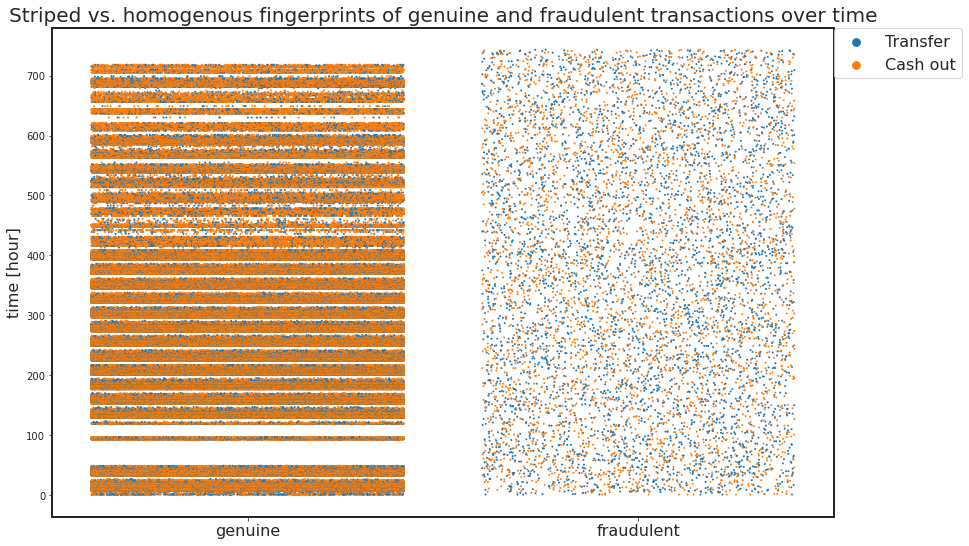

In [47]:
ax = plotStrip(Y[:limit], X.step[:limit], X.type[:limit])
ax.set_ylabel('time [hour]', size = 16)
ax.set_title('Striped vs. homogenous fingerprints of genuine and fraudulent \
transactions over time', size = 20);
plt.show()

5.2 Dispersion over amount:
The two plots below shows that although the presence of fraud in a transaction can be discerned by the original amount feature, the new errorBalanceDest feature is more effective at making a distinction.

C:\Users\subha\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


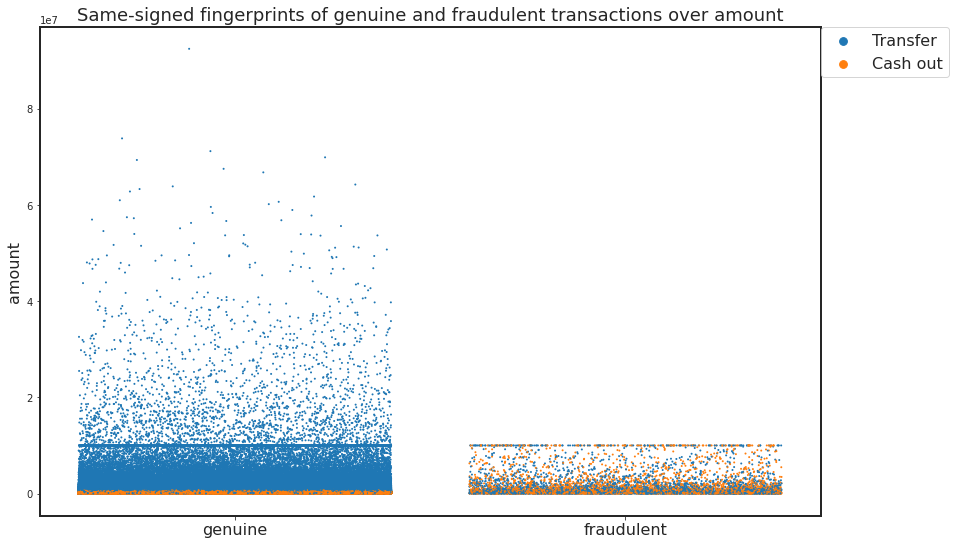

In [48]:
limit = len(X)
ax = plotStrip(Y[:limit], X.amount[:limit], X.type[:limit], figsize = (14, 9))
ax.set_ylabel('amount', size = 16)
ax.set_title('Same-signed fingerprints of genuine \
and fraudulent transactions over amount', size = 18);

5. 3. Dispersion over error in balance in destination accounts:


-  

C:\Users\subha\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


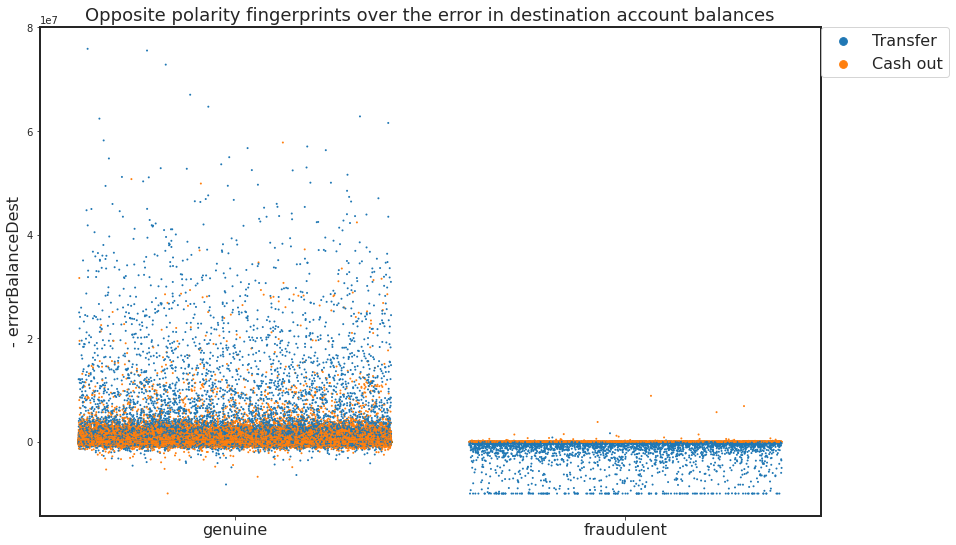

In [49]:
limit = len(X)
ax = plotStrip(Y[:limit], - X.errorBalanceDest[:limit], X.type[:limit], \
              figsize = (14, 9))
ax.set_ylabel('- errorBalanceDest', size = 16)
ax.set_title('Opposite polarity fingerprints over the error in \
destination account balances', size = 18);

5. 4. Separating out genuine from fraudulent transactions:

- The 3D plot below distinguishes best between fraud and non-fraud data by using both of newly derived features:

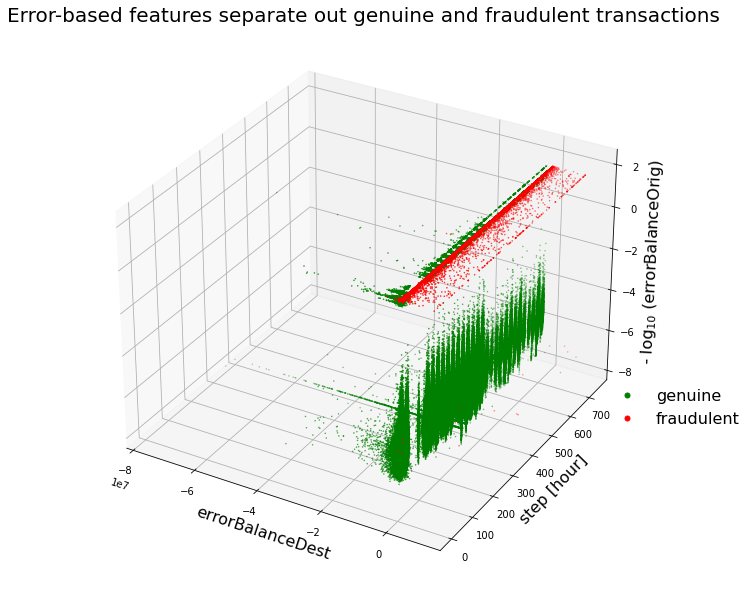

In [50]:
# Long computation in this cell (~2.5 minutes)
x = 'errorBalanceDest'
y = 'step'
z = 'errorBalanceOrig'
zOffset = 0.02
limit = len(X)

sns.reset_orig() # prevent seaborn from over-riding mplot3d defaults

fig = plt.figure(figsize = (10, 12))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X.loc[Y == 0, x][:limit], X.loc[Y == 0, y][:limit], \
  -np.log10(X.loc[Y == 0, z][:limit] + zOffset), c = 'g', marker = '.', \
  s = 1, label = 'genuine')
    
ax.scatter(X.loc[Y == 1, x][:limit], X.loc[Y == 1, y][:limit], \
  -np.log10(X.loc[Y == 1, z][:limit] + zOffset), c = 'r', marker = '.', \
  s = 1, label = 'fraudulent')

ax.set_xlabel(x, size = 16); 
ax.set_ylabel(y + ' [hour]', size = 16); 
ax.set_zlabel('- log$_{10}$ (' + z + ')', size = 16)
ax.set_title('Error-based features separate out genuine and fraudulent \
transactions', size = 20)

plt.axis('tight')
ax.grid(1)

noFraudMarker = mlines.Line2D([], [], linewidth = 0, color='g', marker='.',
                          markersize = 10, label='genuine')
fraudMarker = mlines.Line2D([], [], linewidth = 0, color='r', marker='.',
                          markersize = 10, label='fraudulent')

plt.legend(handles = [noFraudMarker, fraudMarker], \
           bbox_to_anchor = (1.20, 0.38 ), frameon = False, prop={'size': 16});

5.5 Tracking down the coorelations between all the features in fradulent and non-fradulent transactions:

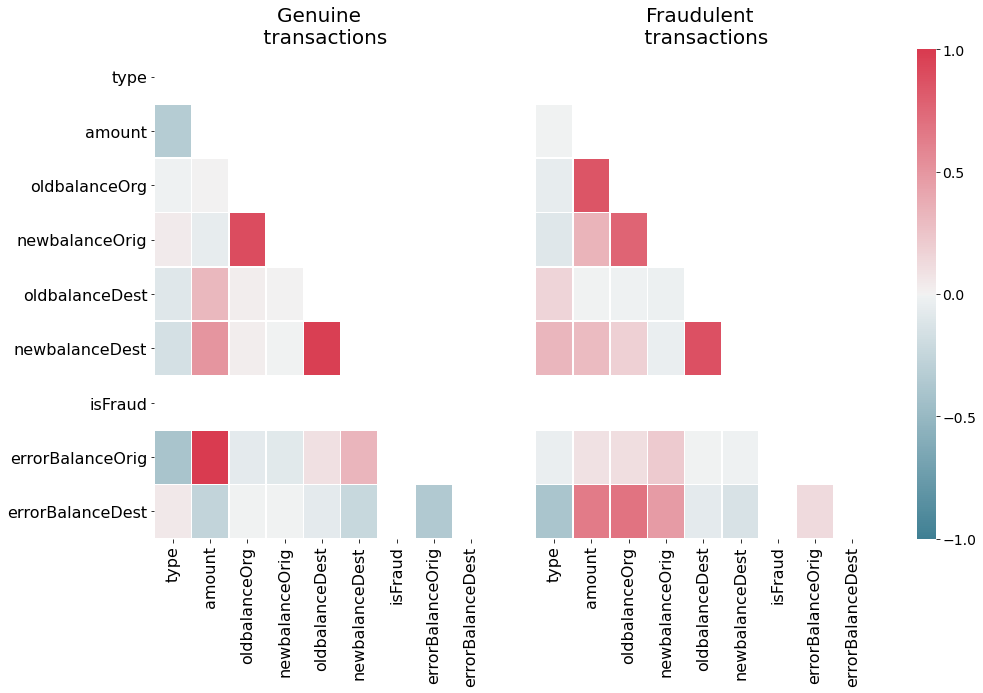

In [51]:
Xfraud = X.loc[Y == 1] # update Xfraud & XnonFraud with cleaned data
XnonFraud = X.loc[Y == 0]
                  
correlationNonFraud = XnonFraud.loc[:, X.columns != 'step'].corr()
mask = np.zeros_like(correlationNonFraud)
indices = np.triu_indices_from(correlationNonFraud)
mask[indices] = True

grid_kws = {"width_ratios": (.9, .9, .05), "wspace": 0.2}
f, (ax1, ax2, cbar_ax) = plt.subplots(1, 3, gridspec_kw=grid_kws, \
                                     figsize = (14, 9))

cmap = sns.diverging_palette(220, 8, as_cmap=True)
ax1 =sns.heatmap(correlationNonFraud, ax = ax1, vmin = -1, vmax = 1, \
    cmap = cmap, square = False, linewidths = 0.5, mask = mask, cbar = False)
ax1.set_xticklabels(ax1.get_xticklabels(), size = 16); 
ax1.set_yticklabels(ax1.get_yticklabels(), size = 16); 
ax1.set_title('Genuine \n transactions', size = 20)

correlationFraud = Xfraud.loc[:, X.columns != 'step'].corr()
ax2 = sns.heatmap(correlationFraud, vmin = -1, vmax = 1, cmap = cmap, \
 ax = ax2, square = False, linewidths = 0.5, mask = mask, yticklabels = False, \
    cbar_ax = cbar_ax, cbar_kws={'orientation': 'vertical', \
                                 'ticks': [-1, -0.5, 0, 0.5, 1]})
ax2.set_xticklabels(ax2.get_xticklabels(), size = 16); 
ax2.set_title('Fraudulent \n transactions', size = 20);

cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(), size = 14);

- here We can see the in case of fradulent transactions, amount is highly correlated with errorBalanceDest.

### 6. Machine Learning to Detect Fraud in Skewed Data

- The target value is highly imbalanced.

- In case of highly imbalanced data, we use the area under the precision-recall curve (AUPRC) rather than the conventional area under the receiver operating characteristic (AUROC)

In [52]:
Xfraud.shape

(8213, 10)

In [53]:

XnonFraud.shape

(2762196, 10)

In [54]:
df['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [55]:
    print('skew = {}'.format( len(Xfraud) / float(len(X)) ))

skew = 0.002964544224336551


### Splitting of the data 

In [56]:
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.2, \
                                                random_state = 5)

In [57]:
print(trainX.shape)
print(testX.shape)
print(trainY.shape)
print(testY.shape)

(2216327, 10)
(554082, 10)
(2216327,)
(554082,)


In [58]:
Y.value_counts()

0    2762196
1       8213
Name: isFraud, dtype: int64

### Building the model by using XGBoost

In [61]:
# Long computation in this cell (~1.8 minutes)
weights = (Y == 0).sum() / (1.0 * (Y == 1).sum())
clf = XGBClassifier(max_depth = 3, scale_pos_weight = weights, \
                n_jobs = 4)
probabilities = clf.fit(trainX, trainY).predict_proba(testX)
print('AUPRC = {}'.format(average_precision_score(testY, \
                                              probabilities[:, 1])))

C:\Users\subha\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:18:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUPRC = 1.0


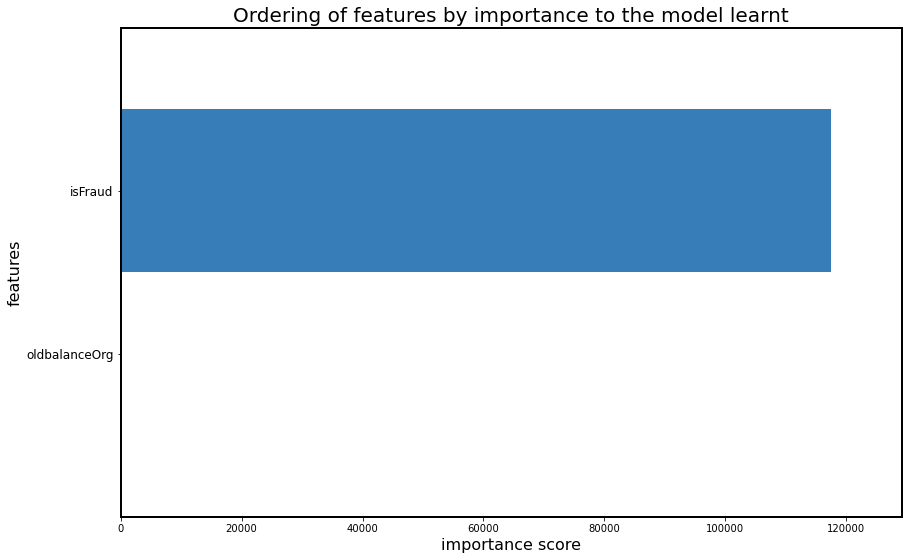

In [62]:
fig = plt.figure(figsize = (14, 9))
ax = fig.add_subplot(111)

colours = plt.cm.Set1(np.linspace(0, 1, 9))

ax = plot_importance(clf, height = 1, color = colours, grid = False, \
                     show_values = False, importance_type = 'cover', ax = ax);
for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)
        
ax.set_xlabel('importance score', size = 16);
ax.set_ylabel('features', size = 16);
ax.set_yticklabels(ax.get_yticklabels(), size = 12);
ax.set_title('Ordering of features by importance to the model learnt', size = 20);

In [63]:
y_pred=clf.predict(testX)

In [64]:
testY

2537487    0
1529076    0
1105070    0
6111087    0
807999     0
          ..
912938     0
4420153    0
3801565    0
4524766    0
2507478    0
Name: isFraud, Length: 554082, dtype: int64

In [65]:
y_pred= probabilities[:, 1]
y_pred

array([4.0391993e-07, 4.9773246e-07, 4.0391993e-07, ..., 4.0391993e-07,
       4.0391993e-07, 4.0391993e-07], dtype=float32)

In [66]:
print('AUPRC = {}'.format(average_precision_score(testY, \
                                              probabilities[:, 1])))

AUPRC = 1.0


In [67]:
from sklearn.metrics import confusion_matrix,classification_report

In [68]:
print(confusion_matrix(testY,y_pred))
print(classification_report(testY,y_pred))

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [69]:
clf

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=336.3199805186899, subsample=1,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)

6.1. What are the important features for the ML model?

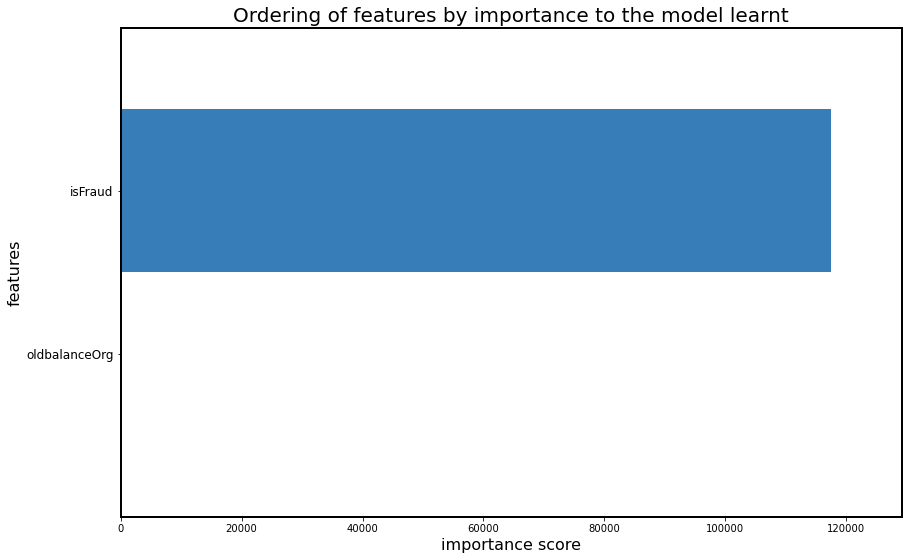

In [70]:
fig = plt.figure(figsize = (14, 9))
ax = fig.add_subplot(111)

colours = plt.cm.Set1(np.linspace(0, 1, 9))

ax = plot_importance(clf, height = 1, color = colours, grid = False, \
                     show_values = False, importance_type = 'cover', ax = ax);
for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)
        
ax.set_xlabel('importance score', size = 16);
ax.set_ylabel('features', size = 16);
ax.set_yticklabels(ax.get_yticklabels(), size = 12);
ax.set_title('Ordering of features by importance to the model learnt', size = 20);

### Interpretation of the model and visualization of the model

In [75]:
import os
os.environ["PATH"] += os.pathsep + 'C:/ProgramData/Anaconda3/Library/bin/graphviz/'
to_graphviz(clf)

ExecutableNotFound: failed to execute ['dot', '-Kdot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH

## visualising the Bias and variance tradeoff by using traing and test performance and learning_curve

In [72]:
# Long computation in this cell (~6 minutes)

trainSizes, trainScores, crossValScores = learning_curve(\
XGBClassifier(max_depth = 3, scale_pos_weight = weights, n_jobs = 4), trainX,\
                                         trainY, scoring = 'average_precision')

C:\Users\subha\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:21:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:21:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:21:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:21:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

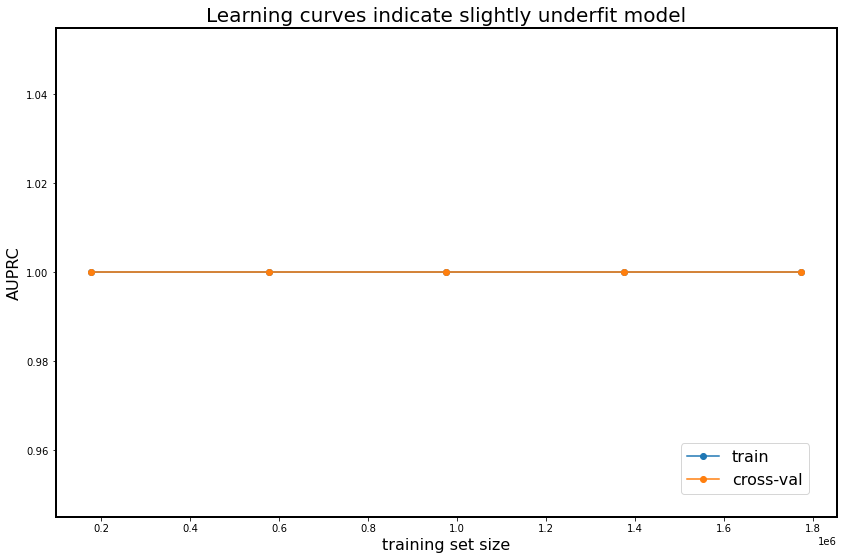

In [73]:
trainScoresMean = np.mean(trainScores, axis=1)
trainScoresStd = np.std(trainScores, axis=1)
crossValScoresMean = np.mean(crossValScores, axis=1)
crossValScoresStd = np.std(crossValScores, axis=1)

colours = plt.cm.tab10(np.linspace(0, 1, 9))

fig = plt.figure(figsize = (14, 9))
plt.fill_between(trainSizes, trainScoresMean - trainScoresStd,
    trainScoresMean + trainScoresStd, alpha=0.1, color=colours[0])
plt.fill_between(trainSizes, crossValScoresMean - crossValScoresStd,
    crossValScoresMean + crossValScoresStd, alpha=0.1, color=colours[1])
plt.plot(trainSizes, trainScores.mean(axis = 1), 'o-', label = 'train', \
         color = colours[0])
plt.plot(trainSizes, crossValScores.mean(axis = 1), 'o-', label = 'cross-val', \
         color = colours[1])

ax = plt.gca()
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, ['train', 'cross-val'], bbox_to_anchor=(0.8, 0.15), \
               loc=2, borderaxespad=0, fontsize = 16);
plt.xlabel('training set size', size = 16); 
plt.ylabel('AUPRC', size = 16)
plt.title('Learning curves indicate slightly underfit model', size = 20);